In [26]:
### IMPORTS
import pandas as pd
import os
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
import numpy as np
import random
from matplotlib.animation import PillowWriter
from datetime import datetime

from matplotlib import pyplot as plt
from PIL import Image
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import plotly.express as px
from plotly.subplots import make_subplots
from matplotlib.colors import Normalize, to_hex
from matplotlib import cm
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors


In [2]:

# Step up to the project root if needed (e.g., if notebook is inside 'notebooks/' or similar)
os.chdir(os.path.abspath(os.path.join(os.getcwd(), "..")))

# Define the base data directory
data_dir = os.path.join("../data", "processed")
beatmaps_path = os.path.join(data_dir, "beatmaps.csv")
user_random_path = os.path.join(data_dir, "random_10000__users.csv")
user_top_path = os.path.join(data_dir, "top_10000__users.csv")

# Load the core datasets
beatmaps_df = pd.read_csv(beatmaps_path)
user_random_df = pd.read_csv(user_random_path)
user_top_df = pd.read_csv(user_top_path)

print("Initial datasets loaded into memory. Remaining data should be loaded on demand.")



Initial datasets loaded into memory. Remaining data should be loaded on demand.


### USER ANALYSIS


#### 1. Playtime distribution 
2 densitiy curves. on x "density on y" one line for random_users one line for top_users

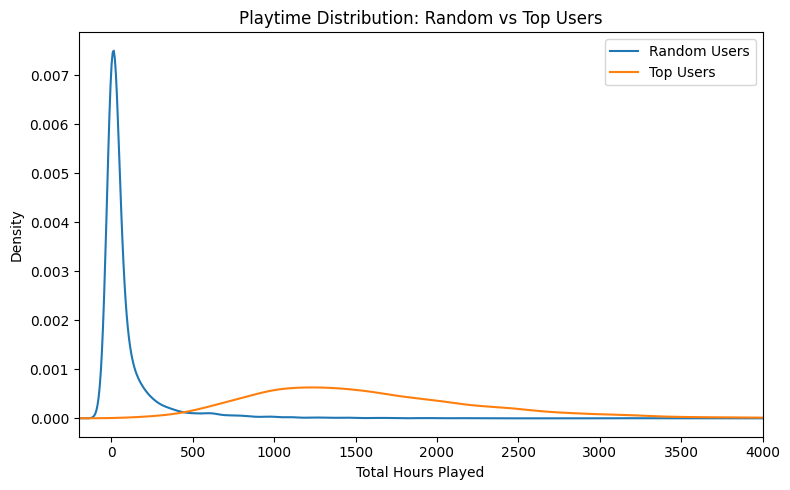

In [21]:
# Convert to hours
random_hours = user_random_df['total_seconds_played'] / 3600
top_hours = user_top_df['total_seconds_played'] / 3600

# Plot
plt.figure(figsize=(8, 5))
random_hours.plot(kind='kde', label='Random Users')
top_hours.plot(kind='kde', label='Top Users')
plt.xlim(-200, 4000)  # Manual scaling from -200 to 4000
plt.xlabel('Total Hours Played')
plt.ylabel('Density')
plt.title('Playtime Distribution: Random vs Top Users')
plt.legend()
plt.tight_layout()
plt.show()

#### 2. 2D Plot: (Nebeneinader Top user und Random)
top 10 Länder as Kreise, Kreis Größe ist Anzahl 
Y: playcount
X: total_seconds

Random users with valid pp: 9220
Top users with valid pp: 9997


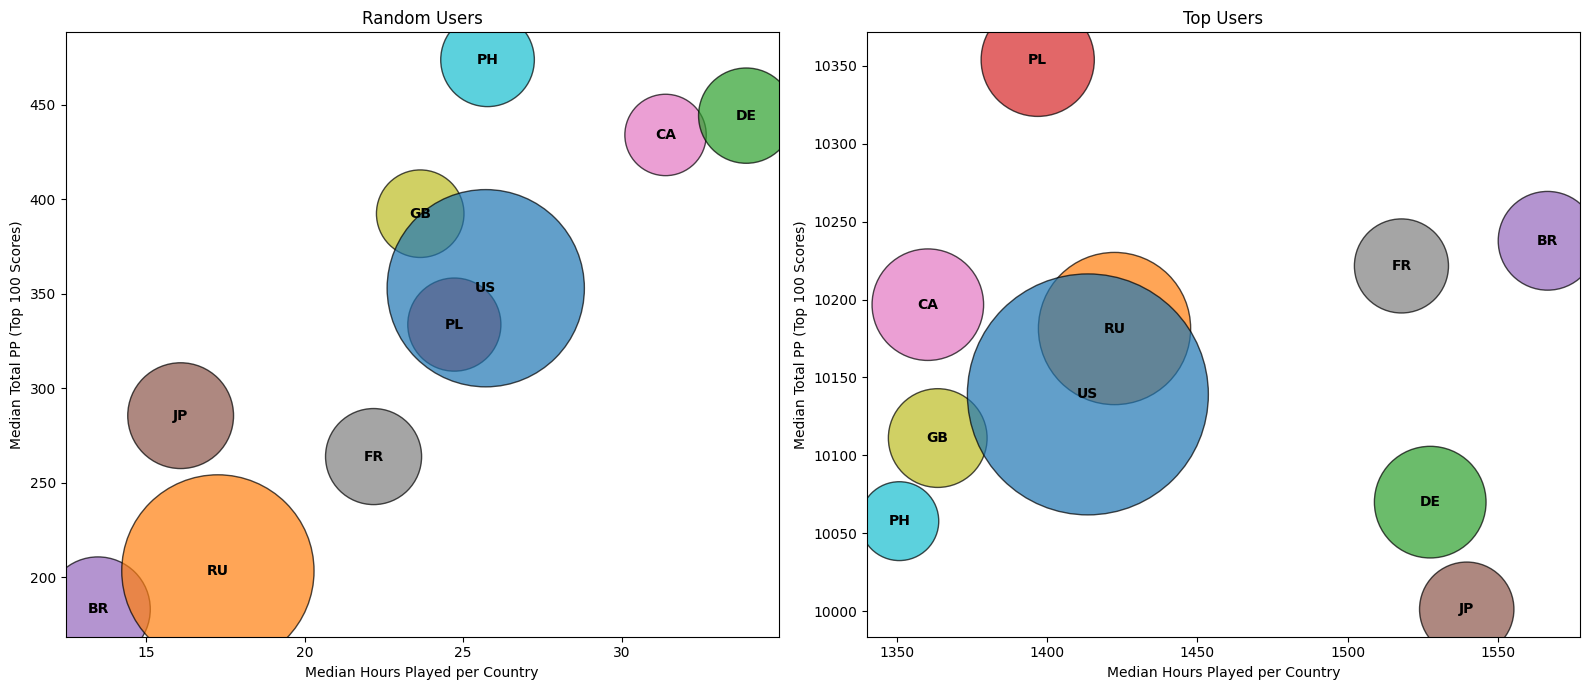

In [52]:

# Load scores
scores_random = pd.read_csv("data/processed/random_10000__scores.csv", usecols=['user_id', 'pp'])
scores_top = pd.read_csv("data/processed/top_10000__scores.csv", usecols=['user_id', 'pp'])
scores_df = pd.concat([scores_random, scores_top], ignore_index=True)

# Filter valid pp
scores_df = scores_df[scores_df['pp'].notna() & (scores_df['pp'] > 0)].copy()

# Sort and rank
scores_df.sort_values(['user_id', 'pp'], ascending=[True, False], inplace=True)
scores_df['rank'] = scores_df.groupby('user_id').cumcount()
scores_df = scores_df[scores_df['rank'] < 100]
scores_df['weight'] = 0.95 ** scores_df['rank']
scores_df['weighted_pp'] = scores_df['pp'] * scores_df['weight']

# Aggregate total pp per user
user_total_pp = scores_df.groupby('user_id')['weighted_pp'].sum().reset_index()
user_total_pp.rename(columns={'weighted_pp': 'total_pp'}, inplace=True)

# --- Load users and combine ---

user_random_df = pd.read_csv("data/processed/random_10000__users.csv", usecols=['user_id', 'country_acronym', 'total_seconds_played'])
user_top_df = pd.read_csv("data/processed/top_10000__users.csv", usecols=['user_id', 'country_acronym', 'total_seconds_played'])

# Add total_pp
user_random_df = user_random_df.merge(user_total_pp, on='user_id', how='left')
user_top_df = user_top_df.merge(user_total_pp, on='user_id', how='left')

# Filter users with valid pp
user_random_df = user_random_df[user_random_df['total_pp'].notna()]
user_top_df = user_top_df[user_top_df['total_pp'].notna()]

# Track how many remain
print(f"Random users with valid pp: {len(user_random_df)}")
print(f"Top users with valid pp: {len(user_top_df)}")

# --- Shared top countries ---
combined_users = pd.concat([user_random_df, user_top_df])
top_countries = (
    combined_users['country_acronym']
    .value_counts()
    .head(10)
    .index
    .tolist()
)
country_color_map = {country: idx for idx, country in enumerate(top_countries)}

# --- Plot function ---
def plot_country_bubbles(users_df, ax, title, country_color_map):
    users_df = users_df[users_df['country_acronym'].isin(country_color_map.keys())].copy()
    users_df['total_hours_played'] = users_df['total_seconds_played'] / 3600

    grouped = users_df.groupby('country_acronym').agg({
        'total_hours_played': 'median',
        'total_pp': 'median',
        'user_id': 'count'
    }).rename(columns={'user_id': 'count', 'total_pp': 'avg_pp'}).reset_index()

    grouped['color_idx'] = grouped['country_acronym'].map(country_color_map)

    ax.scatter(
        grouped['total_hours_played'],
        grouped['avg_pp'],
        s=grouped['count'] * 15,  # larger bubbles
        c=grouped['color_idx'],
        cmap='tab10',
        alpha=0.7,
        edgecolor='k'
    )

    for _, row in grouped.iterrows():
        ax.annotate(
            row['country_acronym'],
            (row['total_hours_played'], row['avg_pp']),
            fontsize=10, weight='bold', ha='center', va='center'
        )

    ax.set_xlabel('Median Hours Played per Country')
    ax.set_ylabel('Median Total PP (Top 100 Scores)')
    ax.set_title(title)

# --- Final Plot ---
fig, axes = plt.subplots(1, 2, figsize=(16, 7), sharey=False)
plot_country_bubbles(user_random_df, axes[0], 'Random Users', country_color_map)
plot_country_bubbles(user_top_df, axes[1], 'Top Users', country_color_map)
plt.tight_layout()
plt.show()

Matteo
#### Farm vs. Recrational metric plotten irgendwie
pp vs. star diff, playcount
wenn möglich.



C:\Users\glaes\AppData\Local\Temp\ipykernel_18968\3323505718.py:44: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for bin_range, group in ratio_df.groupby('star_bin'):
C:\Users\glaes\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\glaes\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


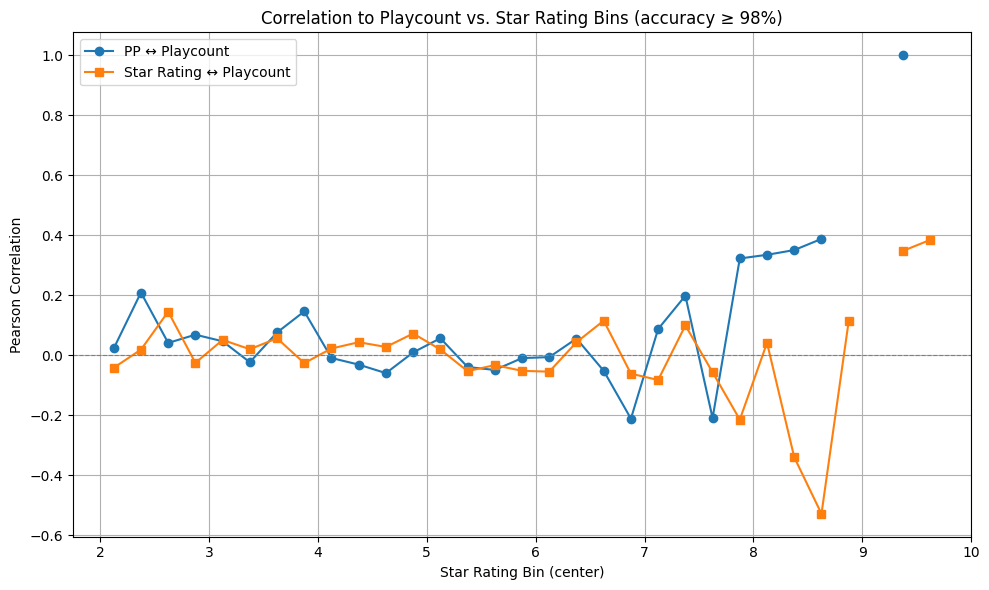

In [11]:
TOP_SCORES_PATH = os.path.join("data", "processed", "top_10000__scores.csv")
RANDOM_SCORES_PATH = os.path.join("data", "processed", "random_10000__scores.csv")

# Constants
TOP_PLAYCOUNT_FRACTION = 0.1  # top 10%

# --- Load and filter beatmaps ---
df = beatmaps_df
df = df[df['mods_string'] == 'NM']
df = df[df['playcount'].notna() & df['beatmap_id'].notna() & df['diff_star_rating'].notna()]
playcount_cutoff = df['playcount'].quantile(1 - TOP_PLAYCOUNT_FRACTION)
df = df[df['playcount'] >= playcount_cutoff].copy()
df = df[['mod_beatmap_id', 'beatmap_id', 'playcount', 'diff_star_rating']]

# --- Load scores and combine ---
top_scores = pd.read_csv(TOP_SCORES_PATH)
random_scores = pd.read_csv(RANDOM_SCORES_PATH)
all_scores = pd.concat([top_scores, random_scores], ignore_index=True)

# --- Filter scores to match mod_beatmap_ids ---
valid_ids = set(df['mod_beatmap_id'])
filtered_scores = all_scores[all_scores['mod_beatmap_id'].isin(valid_ids)]

# --- Filter for accuracy >= 98% ---
filtered_scores = filtered_scores[filtered_scores['accuracy'] >= 0.98]

# --- Compute max pp per mod_beatmap_id ---
max_pp_df = filtered_scores.groupby('mod_beatmap_id')['pp'].max().reset_index()
max_pp_df = max_pp_df.rename(columns={'pp': 'max_pp'})

# --- Merge with beatmap info and compute ratio ---
ratio_df = df.merge(max_pp_df, on='mod_beatmap_id', how='inner')
ratio_df['pp_per_star'] = ratio_df['max_pp'] / ratio_df['diff_star_rating']

# Define finer star rating bins up to 10 stars
bins = np.arange(2.0, 10.25, 0.25)
ratio_df['star_bin'] = pd.cut(ratio_df['diff_star_rating'], bins)

# Store correlations per bin
bin_labels = []
pp_corrs = []
star_corrs = []

for bin_range, group in ratio_df.groupby('star_bin'):
    bin_center = bin_range.mid
    bin_labels.append(bin_center)
    
    if len(group) >= 3:
        pp_corr = group['max_pp'].corr(group['playcount'])
        star_corr = group['diff_star_rating'].corr(group['playcount'])
    else:
        pp_corr = np.nan
        star_corr = np.nan

    pp_corrs.append(pp_corr)
    star_corrs.append(star_corr)

# --- Plot correlations ---
plt.figure(figsize=(10, 6))
plt.plot(bin_labels, pp_corrs, label='PP ↔ Playcount', marker='o')
plt.plot(bin_labels, star_corrs, label='Star Rating ↔ Playcount', marker='s')

plt.xlabel("Star Rating Bin (center)")
plt.ylabel("Pearson Correlation")
plt.title("Correlation to Playcount vs. Star Rating Bins (accuracy ≥ 98%)")
plt.grid(True)
plt.axhline(0, color='gray', linestyle='--', linewidth=0.8)
plt.legend()
plt.tight_layout()
plt.show()


Matteo
#### Limits in phyisically challenging beatmap features.
wenn möglich

In [3]:
# Load scores
scores_path = os.path.join("data", "processed", "random_10000__scores.csv")
scores_df = pd.read_csv(scores_path, parse_dates=["date"])

In [4]:
# Merge with beatmap info
df = scores_df.merge(
    beatmaps_df[['mod_beatmap_id', 'diff_star_rating', 'diff_approach', 'aim', 'speed']],
    on='mod_beatmap_id',
    how='left'
)
print(df.head())

   score_id  mod_beatmap_id  beatmap_id mods_string  user_id     score  \
0         1    704718809258     2993974          DT  7216681  25171143   
1         1    704718809258     2993974          DT  7216681  25171143   
2         2    704718809258     2993974          DT  7216681  25171143   
3         2    704718809258     2993974          DT  7216681  25171143   
4         3    252235386965      795627          DT  7216681  44962419   

        pp  accuracy  maxcombo rank                date  playcount  \
0  904.003    99.000       811    A 2025-03-07 22:11:17         27   
1  904.003    99.000       811    A 2025-03-07 22:11:17         27   
2  904.003    99.000       811    A 2025-03-07 22:11:17         27   
3  904.003    99.000       811    A 2025-03-07 22:11:17         27   
4  859.783    98.998      1328    S 2024-05-15 09:22:36        105   

   diff_star_rating  diff_approach      aim    speed  
0           8.97898            9.4  4.47551  4.07272  
1           8.97898     

In [17]:
# Features to track
features = ['diff_star_rating', 'diff_approach', 'aim', 'speed']

# Select user from top 10% by number of scores
score_counts = df['user_id'].value_counts()
cutoff = np.percentile(score_counts.values, 90)
eligible_users = score_counts[score_counts >= cutoff].index.tolist()
selected_user = random.choice(eligible_users)
user_df = df[df['user_id'] == selected_user].sort_values('date').reset_index(drop=True)

# Chunking
n_chunks = 15
chunks = np.array_split(user_df, n_chunks)

# Feature layout and normalization
feature_y = {f: i for i, f in enumerate(features)}
feature_ranges = {
    f: (
        user_df[f].min() - (user_df[f].max() - user_df[f].min()) * 0.05,
        user_df[f].max() + (user_df[f].max() - user_df[f].min()) * 0.05
    ) for f in features
}

# For black line stats
previous_values = {f: [] for f in features}

# Normalize accuracy range: red at 70%, green at 99%
accuracy_norm = Normalize(vmin=0.80, vmax=0.99)
accuracy_cmap = cm.get_cmap('RdYlGn')

tmp_images = []
for i, chunk in enumerate(chunks):
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.set_ylim(-0.5, len(features) - 0.5)
    ax.set_xlim(0, 1)
    ax.set_yticks(list(feature_y.values()))
    ax.set_yticklabels(features)
    ax.set_title(f"User {selected_user} – Chunk {i+1}/{n_chunks}")

    # Plot each score with accuracy-based color
    for _, row in chunk.iterrows():
        for f in features:
            min_val, max_val = feature_ranges[f]
            norm_val = (row[f] - min_val) / (max_val - min_val) if max_val > min_val else 0.5
            y = feature_y[f] + np.random.uniform(-0.15, 0.15)

            # Normalize accuracy and map to color
            acc = row.get('accuracy', None)
            try:
                acc = float(acc)
                if acc > 1: acc /= 100  # fix if stored as percentage
                acc = max(min(acc, 0.99), 0.80)  # clip to [0.70, 0.99]
                color = to_hex(accuracy_cmap(accuracy_norm(acc)))
            except:
                color = 'gray'

            ax.plot(norm_val, y, 'o', color=color, markeredgecolor='black', markersize=6)

    # Update previous values *before* marker so current chunk is included
    for f in features:
        previous_values[f].extend(chunk[f].dropna().tolist())

    # Add black vertical markers: avg of top 2.5% from all collected so far (inclusive)
    for f in features:
        vals = previous_values[f]
        if vals:
            sorted_vals = sorted(vals, reverse=True)
            top_k = max(1, int(len(sorted_vals) * 0.025))
            avg_top_val = np.mean(sorted_vals[:top_k])

            min_val, max_val = feature_ranges[f]
            norm_val = (avg_top_val - min_val) / (max_val - min_val) if max_val > min_val else 0.5
            y_center = feature_y[f]
            ax.vlines(norm_val, y_center - 0.3, y_center + 0.3, color='black', linestyle='--')

    # Add horizontal feature lines and tick labels
    for f in features:
        y = feature_y[f]
        ax.hlines(y, 0, 1, color='gray', linewidth=0.5, linestyle='-')

        min_val, max_val = feature_ranges[f]
        tick_positions = np.linspace(0, 1, 7)
        tick_labels = [f"{min_val + (max_val - min_val)*p:.2f}" for p in tick_positions]
        for pos, label in zip(tick_positions, tick_labels):
            ax.text(pos, y - 0.32, label, ha='center', va='top', fontsize=7, color='gray')

    plt.tight_layout()
    frame_path = f"frame_{i}.png"
    plt.savefig(frame_path)
    tmp_images.append(Image.open(frame_path))
    plt.close()

# Save the animated GIF
gif_path = os.path.join("data", "processed", f"user_{selected_user}_progression.gif")
tmp_images[0].save(gif_path, save_all=True, append_images=tmp_images[1:], duration=2000, loop=0)

# Clean up temp images
for i in range(len(tmp_images)):
    os.remove(f"frame_{i}.png")

print(f"Saved GIF to: {gif_path}")

C:\Users\glaes\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
C:\Users\glaes\AppData\Local\Temp\ipykernel_23984\2157566023.py:29: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  accuracy_cmap = cm.get_cmap('RdYlGn')


Saved GIF to: data\processed\user_13032979_progression.gif


### BEATMAP ANALYSIS


#### 1. Long tail of beatmaps (beatmap_id not mod_beatmap_id) distribution of playcount

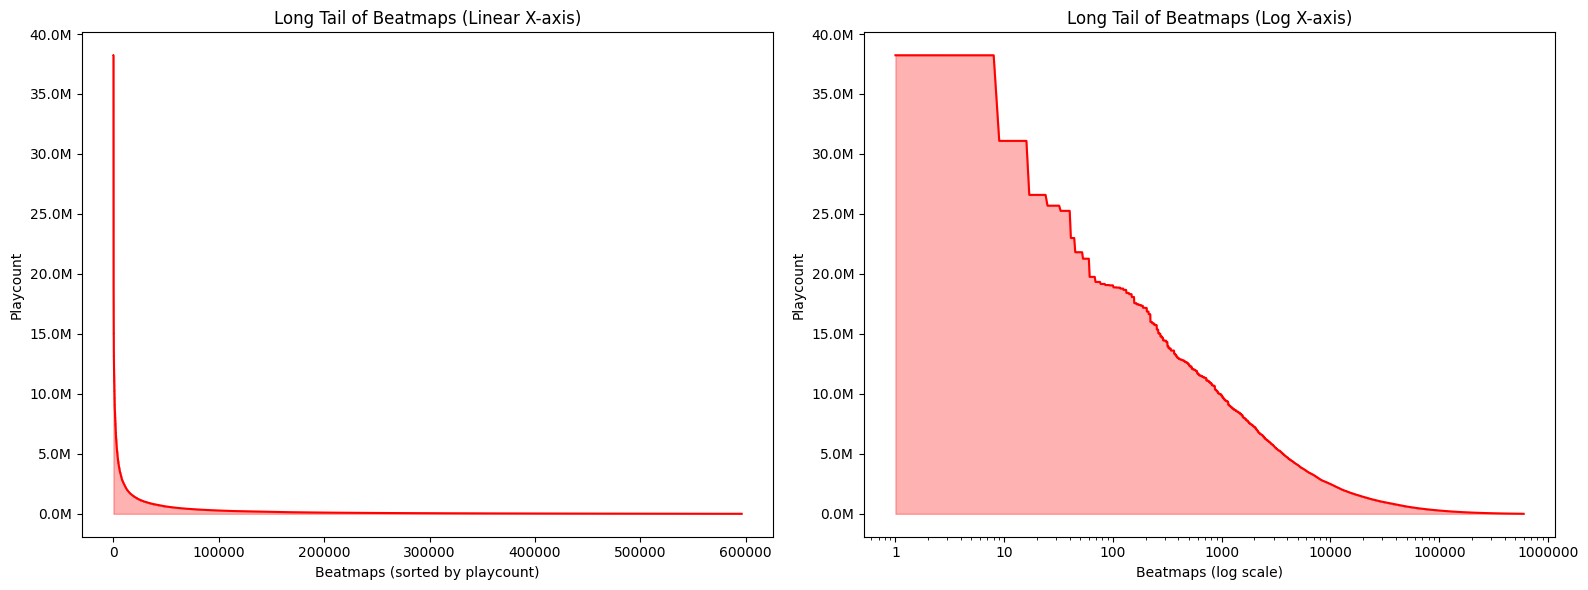

In [44]:
# Ensure valid playcounts
sorted_playcounts = (
    beatmaps_df['playcount']
    .dropna()
    .astype(int)
    .sort_values(ascending=False)
    .reset_index(drop=True)
)

# Setup figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

# Custom formatter for millions
def millions_formatter(x, pos):
    return f'{x / 1_000_000:.1f}M'

y_formatter = ticker.FuncFormatter(millions_formatter)

# --- Linear X-axis plot ---
axes[0].plot(sorted_playcounts, color='red', linewidth=1.5)
axes[0].fill_between(range(len(sorted_playcounts)), sorted_playcounts, color='red', alpha=0.3)
axes[0].set_title("Long Tail of Beatmaps (Linear X-axis)")
axes[0].set_xlabel("Beatmaps (sorted by playcount)")
axes[0].set_ylabel("Playcount")
axes[0].yaxis.set_major_formatter(y_formatter)

# --- Logarithmic X-axis plot ---
x_log = np.arange(1, len(sorted_playcounts) + 1)
axes[1].semilogx(x_log, sorted_playcounts, color='red', linewidth=1.5)
axes[1].fill_between(x_log, sorted_playcounts, color='red', alpha=0.3)
axes[1].set_title("Long Tail of Beatmaps (Log X-axis)")
axes[1].set_xlabel("Beatmaps (log scale)")
axes[1].set_ylabel("Playcount")
axes[1].set_xscale('log')
axes[1].yaxis.set_major_formatter(y_formatter)

# Force Y-axis labels on the second plot
axes[1].tick_params(axis='y', labelleft=True)

# Set clean X ticks
max_tick = 10 ** int(np.ceil(np.log10(len(sorted_playcounts))))
ticks = [10 ** i for i in range(0, int(np.log10(max_tick)) + 1)]
axes[1].set_xticks(ticks)
axes[1].set_xticklabels([str(t) for t in ticks])
axes[1].grid(False)

plt.tight_layout()
plt.show()

In [ ]:
# Features to track
features = ['diff_star_rating', 'diff_approach', 'aim', 'speed']

# Select user from top 10% by number of scores
score_counts = df['user_id'].value_counts()
cutoff = np.percentile(score_counts.values, 90)
eligible_users = score_counts[score_counts >= cutoff].index.tolist()
selected_user = random.choice(eligible_users)
user_df = df[df['user_id'] == selected_user].sort_values('date').reset_index(drop=True)

# Chunking
n_chunks = 15
chunks = np.array_split(user_df, n_chunks)

# Feature layout and normalization
feature_y = {f: i for i, f in enumerate(features)}
feature_ranges = {
    f: (
        user_df[f].min() - (user_df[f].max() - user_df[f].min()) * 0.05,
        user_df[f].max() + (user_df[f].max() - user_df[f].min()) * 0.05
    ) for f in features
}

# For black line stats
previous_values = {f: [] for f in features}

# Normalize accuracy range: red at 70%, green at 99%
accuracy_norm = Normalize(vmin=0.80, vmax=0.99)
accuracy_cmap = cm.get_cmap('RdYlGn')

tmp_images = []
for i, chunk in enumerate(chunks):
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.set_ylim(-0.5, len(features) - 0.5)
    ax.set_xlim(0, 1)
    ax.set_yticks(list(feature_y.values()))
    ax.set_yticklabels(features)
    ax.set_title(f"User {selected_user} – Chunk {i+1}/{n_chunks}")

    # Plot each score with accuracy-based color
    for _, row in chunk.iterrows():
        for f in features:
            min_val, max_val = feature_ranges[f]
            norm_val = (row[f] - min_val) / (max_val - min_val) if max_val > min_val else 0.5
            y = feature_y[f] + np.random.uniform(-0.15, 0.15)

            # Normalize accuracy and map to color
            acc = row.get('accuracy', None)
            try:
                acc = float(acc)
                if acc > 1: acc /= 100  # fix if stored as percentage
                acc = max(min(acc, 0.99), 0.80)  # clip to [0.70, 0.99]
                color = to_hex(accuracy_cmap(accuracy_norm(acc)))
            except:
                color = 'gray'

            ax.plot(norm_val, y, 'o', color=color, markeredgecolor='black', markersize=6)

    # Update previous values *before* marker so current chunk is included
    for f in features:
        previous_values[f].extend(chunk[f].dropna().tolist())

    # Add black vertical markers: avg of top 2.5% from all collected so far (inclusive)
    for f in features:
        vals = previous_values[f]
        if vals:
            sorted_vals = sorted(vals, reverse=True)
            top_k = max(1, int(len(sorted_vals) * 0.025))
            avg_top_val = np.mean(sorted_vals[:top_k])

            min_val, max_val = feature_ranges[f]
            norm_val = (avg_top_val - min_val) / (max_val - min_val) if max_val > min_val else 0.5
            y_center = feature_y[f]
            ax.vlines(norm_val, y_center - 0.3, y_center + 0.3, color='black', linestyle='--')

    # Add horizontal feature lines and tick labels
    for f in features:
        y = feature_y[f]
        ax.hlines(y, 0, 1, color='gray', linewidth=0.5, linestyle='-')

        min_val, max_val = feature_ranges[f]
        tick_positions = np.linspace(0, 1, 7)
        tick_labels = [f"{min_val + (max_val - min_val)*p:.2f}" for p in tick_positions]
        for pos, label in zip(tick_positions, tick_labels):
            ax.text(pos, y - 0.32, label, ha='center', va='top', fontsize=7, color='gray')

    plt.tight_layout()
    frame_path = f"frame_{i}.png"
    plt.savefig(frame_path)
    tmp_images.append(Image.open(frame_path))
    plt.close()

# Save the animated GIF
gif_path = os.path.join("data", "processed", f"user_{selected_user}_progression.gif")
tmp_images[0].save(gif_path, save_all=True, append_images=tmp_images[1:], duration=2000, loop=0)

# Clean up temp images
for i in range(len(tmp_images)):
    os.remove(f"frame_{i}.png")

print(f"Saved GIF to: {gif_path}")

C:\Users\glaes\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
C:\Users\glaes\AppData\Local\Temp\ipykernel_23984\2157566023.py:29: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  accuracy_cmap = cm.get_cmap('RdYlGn')


Saved GIF to: data\processed\user_13032979_progression.gif


Sonja
#### 2. beatmaps anzahl über Zeit. 

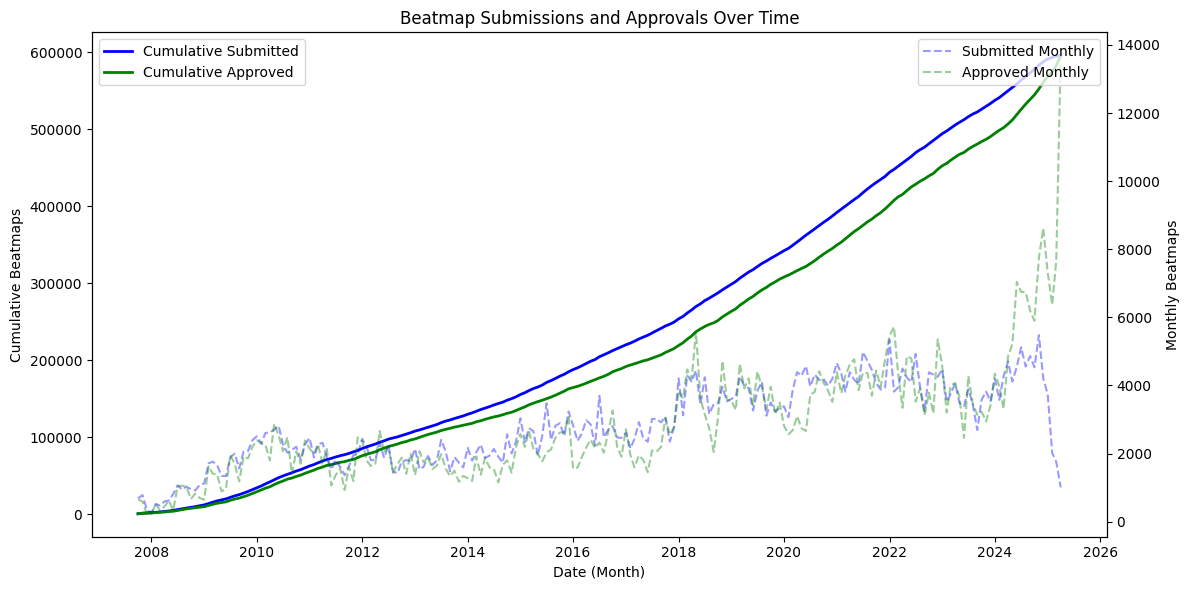

In [48]:
import matplotlib.pyplot as plt

# Ensure dates are datetime
beatmaps_df['submit_date'] = pd.to_datetime(beatmaps_df['submit_date'], errors='coerce')
beatmaps_df['approved_date'] = pd.to_datetime(beatmaps_df['approved_date'], errors='coerce')

# Group by month
submitted_monthly = beatmaps_df.groupby(beatmaps_df['submit_date'].dt.to_period('M')).size()
approved_monthly = beatmaps_df.groupby(beatmaps_df['approved_date'].dt.to_period('M')).size()

# Convert to timestamps
submitted_monthly.index = submitted_monthly.index.to_timestamp()
approved_monthly.index = approved_monthly.index.to_timestamp()

# Cumulative sums
submitted_cumsum = submitted_monthly.cumsum()
approved_cumsum = approved_monthly.cumsum()

# Plot
fig, ax1 = plt.subplots(figsize=(12, 6))

# Cumulative on left y-axis
ax1.plot(submitted_cumsum, label='Cumulative Submitted', color='blue', linewidth=2)
ax1.plot(approved_cumsum, label='Cumulative Approved', color='green', linewidth=2)
ax1.set_ylabel('Cumulative Beatmaps')
ax1.set_xlabel('Date (Month)')
ax1.legend(loc='upper left')

# Monthly counts on right y-axis
ax2 = ax1.twinx()
ax2.plot(submitted_monthly, label='Submitted Monthly', color='blue', linestyle='--', alpha=0.4)
ax2.plot(approved_monthly, label='Approved Monthly', color='green', linestyle='--', alpha=0.4)
ax2.set_ylabel('Monthly Beatmaps')
ax2.legend(loc='upper right')

plt.title("Beatmap Submissions and Approvals Over Time")
plt.tight_layout()
plt.show()


Matteo
#### 2. Map Archetype Sketch. 
1. use beatmaps_df
3D plot plotting beatmaps along the 3 dimensions: speed, aim, technicality(combination of slider_factor and inverse passrate(passcount/playcount) maybe or something similar), and color of points should be scaled along diffstar rating.
Assumption: Patterns will emerge. 

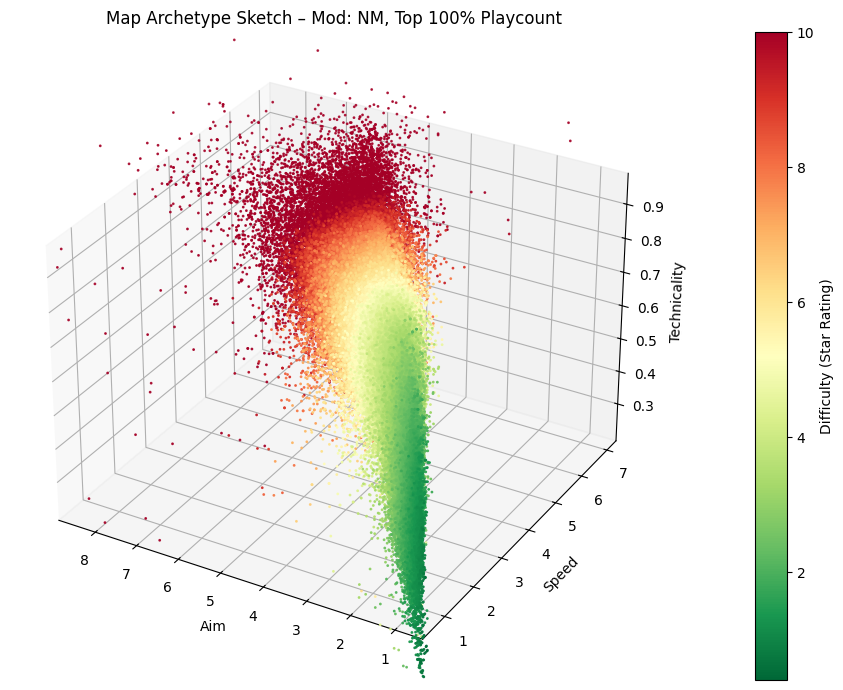

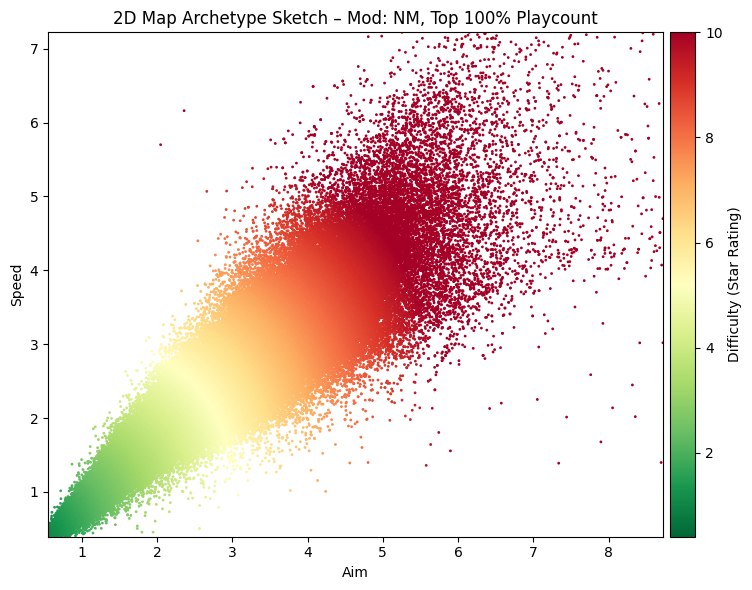

In [9]:
# --- Tunable Parameters ---
MOD_FILTER = "NM"
MAX_DIFF_STAR = 10
CLIP_PERCENTILE_RANGE = 0.999       
TOP_PLAYCOUNT_FRACTION = 1.0      # top 10% by playcount
DOT_SIZE = 1.0  # Controls marker size in scatter plot


# --- Filtering & Feature Engineering ---
df = beatmaps_df.copy()

# Filter by MOD
#df = df[df['mods_string'] == MOD_FILTER]

# Remove rows with missing values in relevant columns
df = df[
    df['aim'].notna() &
    df['speed'].notna() &
    df['slider_factor'].notna() &
    df['passcount'].notna() &
    df['playcount'].notna() &
    df['playcount'] > 0 &
    df['diff_star_rating'].notna()
]

# Compute technicality: sliders × (1 - passrate)
df['technicality'] = df['slider_factor'] * (1 - df['passcount'] / df['playcount'])

# Cap difficulty rating
df['diff_star_rating'] = df['diff_star_rating'].clip(upper=MAX_DIFF_STAR)

# Select top X% of beatmaps by playcount
playcount_cutoff = df['playcount'].quantile(1 - TOP_PLAYCOUNT_FRACTION)
df = df[df['playcount'] >= playcount_cutoff]

# Get axis value ranges based on CLIP_PERCENTILE_RANGE
clip_low = (1 - CLIP_PERCENTILE_RANGE) / 2
clip_high = 1 - clip_low
def get_range(series):
    return series.quantile(clip_low), series.quantile(clip_high)

aim_min, aim_max = get_range(df['aim'])
speed_min, speed_max = get_range(df['speed'])
tech_min, tech_max = get_range(df['technicality'])



# --- 3D Plot ---

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(
    df['aim'], df['speed'], df['technicality'],
    c=df['diff_star_rating'], cmap='RdYlGn_r',  s=DOT_SIZE
)

# Axes settings
ax.set_xlabel('Aim')
ax.set_ylabel('Speed')
ax.set_zlabel('Technicality')
ax.set_xlim(aim_min, aim_max)
ax.set_ylim(speed_min, speed_max)
ax.set_zlim(tech_min, tech_max)

# Colorbar
cbar = fig.colorbar(scatter, ax=ax, pad=0.1)
cbar.set_label('Difficulty (Star Rating)')

ax.set_title(f"Map Archetype Sketch – Mod: {MOD_FILTER}, Top {int(TOP_PLAYCOUNT_FRACTION*100)}% Playcount")

# Ensure all axes go from low to high
if aim_min > aim_max:
    ax.set_xlim(aim_max, aim_min)
else:
    ax.set_xlim(aim_min, aim_max)

if speed_min > speed_max:
    ax.set_ylim(speed_max, speed_min)
else:
    ax.set_ylim(speed_min, speed_max)

if tech_min > tech_max:
    ax.set_zlim(tech_max, tech_min)
else:
    ax.set_zlim(tech_min, tech_max)

# Flip only if needed
ax.set_xlim(aim_min, aim_max)
ax.set_ylim(speed_min, speed_max)
ax.set_zlim(tech_min, tech_max)

# Optionally enforce direction (flip back if matplotlib draws them inverted)

ax.invert_xaxis()

plt.tight_layout()
plt.show()

# --- 2D Plot (Aim vs Speed) ---

fig, ax = plt.subplots(figsize=(8, 6))

scatter = ax.scatter(
    df['aim'], df['speed'],
    c=df['diff_star_rating'], cmap='RdYlGn_r',  s=DOT_SIZE
)



# Axes settings
ax.set_xlabel('Aim')
ax.set_ylabel('Speed')

ax.set_xlim(aim_min, aim_max)
ax.set_ylim(speed_min, speed_max)

# Colorbar
cbar = plt.colorbar(scatter, ax=ax, pad=0.01)
cbar.set_label('Difficulty (Star Rating)')

ax.set_title(f"2D Map Archetype Sketch – Mod: {MOD_FILTER}, Top {int(TOP_PLAYCOUNT_FRACTION * 100)}% Playcount")

plt.tight_layout()
plt.show()



##### Idea: PP show how line on difficulty and accuracy

Matteo
#### how extreme values in "constraint features" reduce players. 

### SCORE ANALYSIS 

Sonja 
# features where formulas changed over time: 
- pp (Variance über Jahre innerhalb Intervalle.)  Anfang intervall - EnderIntervall Änderung des Durchschnitt
- diff_star_rating